# passive capture
=================================

## development

'passive capture' is my first pass at a GeoDjango  application. Regrettably due to time-constraints and package conflicts between Django_2.0/PostGIS/Heroku, I was unable to complete a delivered product that I could reliably host for end use. The application is functional locally, and the code can be viewed/downloaded here: 

[Passive Capture Python github repository](https://github.com/anadromous-data/passive_capture_py)

Although far from perfect, I hope to deliver a crude tool which enable time-series analysis and visualization to fish passage tracking efforts on the Columbia River. It's been a bunch of fun working with a new platform, and experimenting with statistical/GIS packages in python I may have not had the chance to use otherwise. As time allows, I hope to complete the application, and provide hosting and improvements.

objectives
----------

*   **To provide a tool which enables users to create custom time-series forecasts and visualizations for anadramous fish returns along the Columbia River.**

*   **Compare the efficacy of Facebook's open source time series statistical package versus traditional ARIMA methods**

technologies utilized
---------------------

*   Python 3
*   GeoDjango
*   QGIS 3
*   BigQuery
*   PostGIS
*   Leaflet/Folium

setup
-----

Below are my notes taken during the devleopment of this application

I've taken a crack at fish passage modeling before, and felt that using the US Army Core of Engineers (USACE) fish passage data for the Columbia River would be the most familiar and applicable for this project. The Fish Passage Center ([FPC](fpc.org/http://www.fpc.org/documents/metadata/FPC\_Adult\_Metadata.html)) provides a great interface to collect this data, and I've developed APIs in both [Ruby](https://github.com/anadromous-data/passive-capture) and [R](https://github.com/anadromous-data/fishpassagecenterr) to query the current days data.

I wanted to work with a static set of data initially, as it would require less API overhead than to keep and API up and running to ETL (Extract, Transform, Load) the FPC data on a schedule

**First Steps:**

*   Downlaod a fresh set of passage / flow data for all dam sites ranging 2010 - 2018
*   Create a job to load them into BigQuery
*   Normalize and extract the data to CSV

**Example Query to normalize the FPC Data Into BigQuery**

```
SELECT 
    PARSE_DATE("%m/%d/%Y", date) AS count_date,
    dam,
    ChinookAdult AS chinook_adult,
    ChinookJack AS chinook_jack,
    CohoAdult AS coho_adult,
    CohoJack AS coho_jack,
    Steelhead AS steelhead,
    WildSteelhead AS wild_steelhead,
    Sockeye AS sockeye,
    Pink AS pink,
    Chum AS chum,
    Lamprey AS lamprey,
    Shad As shad
FROM `passive-capture.passage_data.daily_counts`
ORDER BY count_date;
```

**Additonal Data Collected:**

For this project, I'm exicted to experiment with Facebook's Prophet. Prophet procedure is an additive regression model with four main components:

- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

Perhaps the most interesting aspect of Facebook's open source 'prophet' time-series forecasting package is the ability to incorporate additional regressors into model -- something that has traditionally been difficult in time-series analysis software. Other attractive features prophet includes are options to toggle 'seasonality detection', custom seasonality definitions, or add 'holidays'. Holidays are periods of time the model may expect additonal variance in trend, which seemed appropriate for runs of fish -- which occur seasonally.

For autoregessors, I hope to examine the impact of current and historical precipitation and dam flows as impacts to the model. Precipiation in both rain and snow play a driving force in fry and parr survival rates, as well as the timing in which salmon species will either 'hold', or push on with their migration. Flows through the dams as well play a critical part in determining parr/smolt predation and survival rates.

**Autogressors:**

*   Current year/month precipitation totals
*   Current year/month flows from Dam being modeled
*   Current water-year snow/water equivalent standard deviation
*   Historical (3yr) year/month precipitation totals
*   Historical (3yr) year/month flows from Dam being modeled
*   Historical (3yr) water-year snow/water equivalent standard deviation

NOAA Data was extracted from public datasets -- metdata came from https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

**Example for snow data grouped by year month:** 
```
SELECT
    CONCAT( CAST(EXTRACT(YEAR FROM date) AS STRING),
    CAST(EXTRACT(MONTH FROM date) AS STRING) ) AS year_month,
    stations.name,
    stations.latitude,
    stations.longitude,
    weather.id,
    weather.element,
    SUM(weather.value) AS snow_total,
    AVG(DISTINCT weather.value) AS snow_average,
    MIN(weather.value) AS snow_min,
    MAX(weather.value) AS snow_max
FROM `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations JOIN `bigquery-public-data.ghcn_d.ghcnd_201*` AS weather ON weather.id = stations.id WHERE stations.latitude > 43 AND stations.latitude < 49 AND stations.longitude > -123 AND stations.longitude < -120 AND element = 'SNWD'
GROUP BY year_month, stations.name, stations.latitude, stations.longitude, weather.id, weather.element
ORDER BY year_month
```

statistical notes
-----------------

At present moment, there are 2 models I would like to pursue with this project. The first is a composite model between ARIMA and Prophet utilizing seasonality per distinct andaramous fish run and weather and flow features as autoregessors. The second would be ARIMA/Prophet time series analysis on each individual feature including run counts, flow, dissolved gas, precipitation etc -- and then compose a multivariate regression model using the predicted future values that may/may not contribute to run counts.

I'm taking the log of the run counts because the variance in any given sample over the time series differs significantly. In log-log regression model it is the interpretation of estimated parameter, say αi as the elasticity of Y(t) on Xi(t). In error-correction models we have an empirically stronger assumption that proportions are more stable (stationary) than the absolute differences. It is easier to aggregate the log-returns over time.

If you still want a statistical criterion for when to do log transformation a simple solution would be any test for heteroscedasticity. In the case of increasing variance I would recommend Goldfeld-Quandt Test or similar to it. In R it is located in library(lmtest) and is denoted by gqtest(y~1) function. Simply regress on intercept term if you don't have any regression model, y is your dependent variable.

# demonstration

### setup

In [3]:
import os
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
# Ignore upcoming deprecation warnings in the notebook
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### prepare the data for forecasting

The [`forecast_generator.py`](https://github.com/anadromous-data/passive_capture_py/blob/master/passive_capture/reporter/forecast_generator.py) script is where we download, clean, predict, and store the data for time-series analysis


In [4]:
# method to clean and format the dataframe for analysis. arguments are the CSV as formatted from FPC, the species to target,
# and whether to display a 'count' of fish, or the log(count)

csv = './csv/passage_data/bon_passage_data.csv'
spp = 'chinook_adult'

def create_dataframe(csv, spp, display_count=False):
  df = pd.read_csv(csv)

  # isolate the dam
  dam_name = df['dam'][0]

  # select columns to remove to isolate a spp
  cols_to_remove = [col for col in df.columns if f"{spp}" not in col and 'count_date' not in col]
  df = df.drop(cols_to_remove, axis=1)
  
  # create date range to accommodate missing dates
  df['count_date'] = pd.to_datetime(df['count_date'])
  idx = pd.date_range(df['count_date'].iloc[0], df['count_date'].iloc[-1])
  df.set_index('count_date',drop=True,inplace=True)
  df = df.reindex(idx, fill_value=0).reset_index()

  # for prophet, format to use ds and y cols
  df['ds'] = df['index']

  # flag return values to be either counts, or the log of the counts
  if display_count:
    df['y'] = df[f"{spp}"]
  else:
    df['y'] = np.log(df[f"{spp}"])
    # replace all -inf 
    df['y'] = df['y'].replace([np.log(0)], 0)

  df = df.drop(['index', f"{spp}"], axis=1)

  return {'dataframe': df, 'dam': dam_name, 'spp': spp}

# run the method:
result_object = create_dataframe(csv,spp)
df = result_object['dataframe']
print('Here is an example output of the normalized dataframe. ds represents the date, and y is a log(count) for a given spp')
df.tail()

Here is an example output of the normalized dataframe. ds represents the date, and y is a log(count) for a given spp


,ds,y
3016,2018-04-05,1.791759
3017,2018-04-06,3.295837
3018,2018-04-07,2.890372
3019,2018-04-08,1.791759
3020,2018-04-09,1.386294


### data normalization
So we have a dataframe which represents our range of data from the first date in the CSV (Jan 1st 2010) to the last (April 9th 2018). 

Some dates were missing so we added them into the dataframe, with 0 count for the fish count. That, as long as days where no fish passed, account for the error output stating that `divide by zero encountered in log`. This is due to `log(0)` being undefined (not a real number).

I elected to use the natural log (`log(count)`) instead of the `count` to perform analysis because there is an uneven variance across our error term -- or heteroscedasticity.

Let's explore the variance in our data set by looking at the following two line graphs representing data for chinook adult passage over our time series

## ADULT CHINOOK COUNT AT BONEVILLE AS INTEGER ##


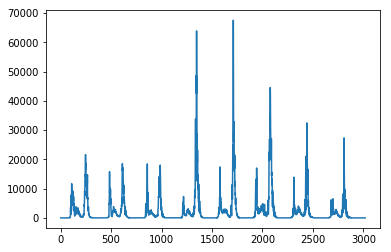

In [5]:
raw_df = pd.read_csv(csv)
print('## ADULT CHINOOK COUNT AT BONEVILLE AS INTEGER ##')
chinook_count = raw_df['chinook_adult']
chinook_count[chinook_count > 0].plot(kind='line')

## ADULT CHINOOK COUNT AT BONEVILLE AS LOG(INTEGER) ##


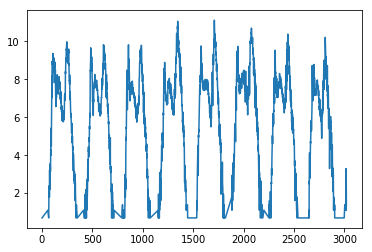

In [6]:
print('## ADULT CHINOOK COUNT AT BONEVILLE AS LOG(INTEGER) ##')
df['y'][df['y'] > 0 ].plot(kind='line')

Just by eyeballing it, it seems as if the `log(count)` forecast will provide more accurate results relatively, and better predict the long-range, highly variant trends we're looking for. As seen below, the minimum value in our set is -1 and the maximum value is 67,521. The variance between days, months, dams and years can also be highly variable.

Let's continue by performing a Breusch-Pagan test for heteroscedasticity v. homoscedasticity. The null hypothesis of the Breusch-Pagan test is homoscedasticity (= variance does not depend on auxiliary regressors). If the p-value is less than .05, the null hypothesis is rejected.
 
We'll have to convert the `count_date` from a string to a numerical value to serve as the independent variable in this experiment. Since we're concerened about month/day time series trends, I wanted to try stacking month/day values.

In [7]:
minimum = raw_df['chinook_adult'].min()
maximum = raw_df['chinook_adult'].max()

print('####')
print('The minimum in the dataframe is', minimum, ' and the maximum is', maximum)
print('####')

# ORIGINAL METHOD TO TRY AND CONVERT DATE STRING TO NUMBERICAL INDEPENDENT VARIABLE
# date = df['count_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').month + datetime.strptime(x, '%Y-%m-%d').day* .01) )

# UPDATED METHOD TO COLUMN STACK MONTH/DAY AS INDEPENDENT VARIABLE
raw_df['month'] = raw_df['count_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
raw_df['day'] = raw_df['count_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)
date = np.column_stack((raw_df['month'],raw_df['day']))
spp_count = raw_df['chinook_adult']

results = smf.OLS(spp_count,date).fit()
print(results.summary())

####
The minimum in the dataframe is -1  and the maximum is 67521
####
                            OLS Regression Results                            
Dep. Variable:          chinook_adult   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     316.3
Date:                Mon, 23 Apr 2018   Prob (F-statistic):          1.92e-125
Time:                        20:53:54   Log-Likelihood:                -30183.
No. Observations:                3018   AIC:                         6.037e+04
Df Residuals:                    3016   BIC:                         6.038e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan

name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
bp = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
bp
pd.DataFrame(name,bp)

,0
1.234807e+02,Lagrange multiplier statistic
1.094481e-28,p-value
6.433152e+01,f-value
4.372090e-28,f p-value


Since our **p-value** is less than 0.05, this indicates that heteroscedasticity is present, and we reject the null hypothesis of homoscedasticity. 

In [9]:
# Reduce heteroscedasticity -- need to normalize log data to perform test
# raw_df['log_chinook_adult'] = np.log(raw_df['chinook_adult'])
# # replace all -inf 
# raw_df['log_chinook_adult'] = raw_df['log_chinook_adult'].replace([np.log(0)], 0)
# log_spp_count = raw_df['log_chinook_adult']

# print(raw_df.describe())

# results = smf.OLS(log_spp_count,date).fit()
# print(results.summary())
# name = ['Lagrange multiplier statistic', 'p-value', 
#         'f-value', 'f p-value']
# bp = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
# bp
# pd.DataFrame(name,bp)




### forecasting
Now that we have cleaned, formatted, and (somewhat) normalized our dataset, let's fit it to prophet and start getting some time-series analysis. 

## ADULT CHINOOK AT BONEVILLE ##


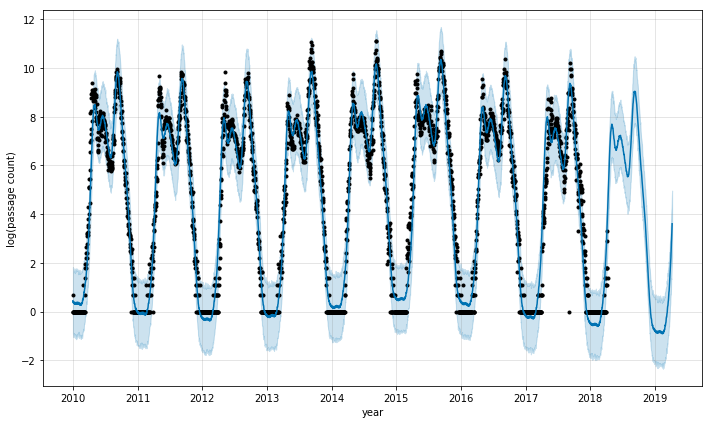

In [10]:
import matplotlib.pyplot as plt
from fbprophet import Prophet

def predict_passage(df,dam,spp,num_of_days):
  m = Prophet(interval_width=0.95, daily_seasonality=False)
  m.fit(df);
  future = m.make_future_dataframe(periods=num_of_days)
  forecast = m.predict(future)
  m.plot(forecast,uncertainty=True,xlabel='year', ylabel='log(passage count)')
  plt.show()
print('## ADULT CHINOOK AT BONEVILLE ##')
predict_passage(result_object['dataframe'],result_object['dam'],result_object['spp'],365)

Impressively, prophet is able to pick up on long-range seasonality trends out-of-the-box, and without any additional autoregressors it's able to predict a line of best fit in this chinook run. Let's try our method again on a dam upstream, as well as a different species.

Let's inspect what's going on a little bit more in the `predict_passage` method:

In [11]:
df = result_object['dataframe']
num_of_days = 30

print("Prophet() instansiates an object")
m = Prophet(interval_width=0.95, daily_seasonality=False)
print("We call the object to fit our dataframe")
m.fit(df);
print("We create a new dataframe with the desired number of days in the future to forecast")
future = m.make_future_dataframe(periods=num_of_days)
print("Prophet outputs a dataframe of it's forecast")
forecast = m.predict(future)
forecast.tail()


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet() instansiates an object
We call the object to fit our dataframe
We create a new dataframe with the desired number of days in the future to forecast
Prophet outputs a dataframe of it's forecast


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
3046,2018-05-05,4.133305,4.132948,4.133305,6.816718,8.521790,3.488857,3.488857,3.488857,3.488857,3.488857,3.488857,-0.029665,-0.029665,-0.029665,3.518522,3.518522,3.518522,7.622162
3047,2018-05-06,4.132467,4.131989,4.132467,6.707138,8.510738,3.493545,3.493545,3.493545,3.493545,3.493545,3.493545,-0.005949,-0.005949,-0.005949,3.499494,3.499494,3.499494,7.626012
3048,2018-05-07,4.131628,4.130982,4.131628,6.768136,8.421485,3.463669,3.463669,3.463669,3.463669,3.463669,3.463669,-0.006572,-0.006572,-0.006572,3.470242,3.470242,3.470242,7.595298
3049,2018-05-08,4.130790,4.130043,4.130790,6.569911,8.365581,3.392816,3.392816,3.392816,3.392816,3.392816,3.392816,-0.039064,-0.039064,-0.039064,3.431880,3.431880,3.431880,7.523605
3050,2018-05-09,4.129951,4.129087,4.129951,6.658728,8.384069,3.399765,3.399765,3.399765,3.399765,3.399765,3.399765,0.014166,0.014166,0.014166,3.385599,3.385599,3.385599,7.529716


Prophet returns a large DataFrame with many interesting columns, but the columns with the most relevant to forecasting are:

- **ds**: the datestamp of the forecasted value
- **yhat**: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- **yhat_lower**: the lower bound of our forecasts
- **yhat_upper**: the upper bound of our forecasts

Prophet also enables us to look more closely at the components used in forecasting.

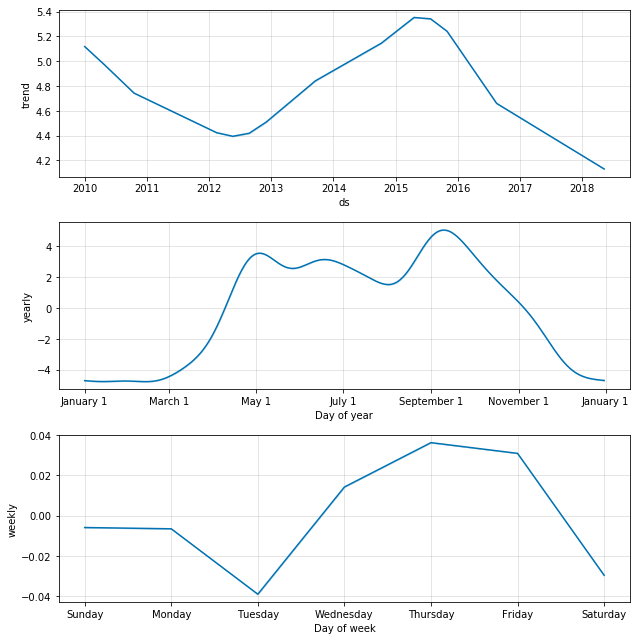

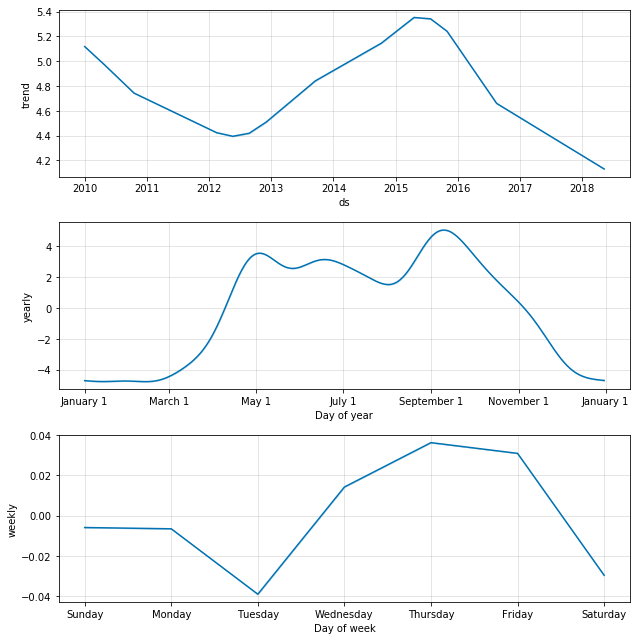

In [12]:
m.plot_components(forecast)

In [13]:
from sklearn.metrics import mean_absolute_error  

df = result_object['dataframe']
df2 = m.predict(df)
df2['y'] = df['y']
# mean_absolute_error(np.exp(df2['yhat_lower']), np.exp(df2['yhat'])) 

## ADULT CHINOOK AT JOHN DAY ##


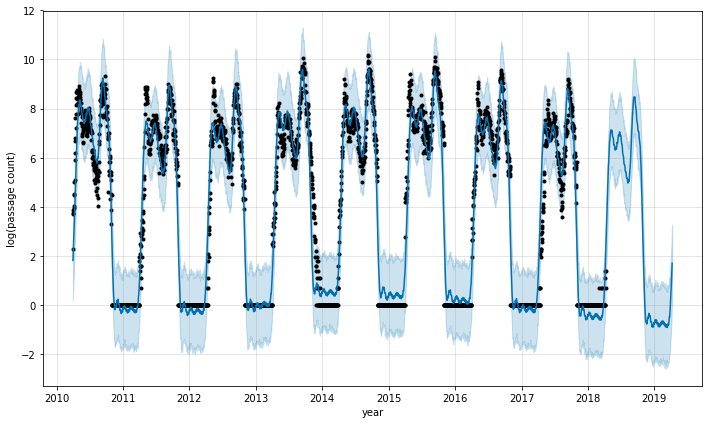

In [14]:
csv = './csv/passage_data/jda_passage_data.csv'
spp = 'chinook_adult'

result_object = create_dataframe(csv,spp)
print('## ADULT CHINOOK AT JOHN DAY ##')
predict_passage(result_object['dataframe'],result_object['dam'],result_object['spp'],365)

## SOCKEYE AT BONEVILLE ##


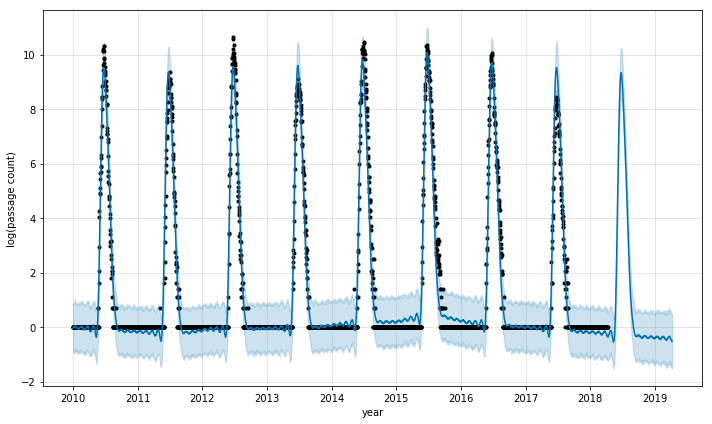

In [15]:
csv = './csv/passage_data/bon_passage_data.csv'
spp = 'sockeye'

result_object = create_dataframe(csv,spp)
print('## SOCKEYE AT BONEVILLE ##')
predict_passage(result_object['dataframe'],result_object['dam'],result_object['spp'],365)

### forecasting next steps
- Evaluate forecasts (mean absolute error, cross-validation over window subsets of data
- Add autogregressors and 'holiday' features defined as the historical average start/end of a particular species run
- Compare with traditional ARIMA models
- Generate multivariate model based off composite time-series forecasting done on individual features (flow, snow-water equivalent, etc.)

### visualizing passage
The Prophet time-series forecasts have exceeded my expectations for time series analysis and performance, and I believe they provide an excellent resource to use in mapping and visualizing fish passage data. 

The next step is to display the information rendered from the forecast visually.

I've been wanting to experiment with `folium` for while now, which is an open source leaflet powered map package for python. I started by getting the lat/long of the dams I wished to visualize, and then experimented with generating a map with markers and two tile layers. 

In [62]:
import folium
from folium import plugins
dam_location_dictionary = {'BON':(45.644167,-121.9449334),
                           'TDA':(45.6125567,-121.137872),
                           'JDA':(45.7148507,-120.6958588),
                           'MCN':(45.9322088,-119.3021506)
                          }

m = folium.Map(location=(45.7,-121.25),
               zoom_start=8
               )

dam_locations = folium.FeatureGroup("Dams")

for key, value in dam_location_dictionary.items():
    dam_locations.add_child(folium.CircleMarker(location=value,
                                       radius=30,
                                       popup=key,
                                       color='#3186cc',
                                       fill=True,
                                       fill_color='#3186cc'))
    

m.add_child(dam_locations)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.LayerControl().add_to(m)
m


In [64]:
dam_df = pd.DataFrame(list(dam_location_dictionary.items()), columns=['name', 'lat/lng'])
print(dam_df)
# convert to (n, 2) nd-array format for heatmap
damArr = dam_df['lat/lng'].as_matrix()
print(damArr)
# plot heatmap
m.add_children(plugins.HeatMap(damArr, radius=15))
m

  name                     lat/lng
0  BON   (45.644167, -121.9449334)
1  TDA   (45.6125567, -121.137872)
2  JDA  (45.7148507, -120.6958588)
3  MCN  (45.9322088, -119.3021506)
[(45.644167, -121.9449334) (45.6125567, -121.137872)
 (45.7148507, -120.6958588) (45.9322088, -119.3021506)]
